In [1]:
from google.colab import drive
drive.mount('/content/drive')

root = "/content/drive/MyDrive/aicv/"

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import os
import sys

from sklearn.neural_network import MLPClassifier

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# to play the audio files
from IPython.display import Audio

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
mfcc_df = pd.read_csv(root + "train_features/minmax/mfcc_mean_feature_minmax.csv")
chroma_df = pd.read_csv(root + "train_features/minmax/chroma_mean_feature_minmax.csv")
mel_df = pd.read_csv(root + "train_features/minmax/mel_mean_feature_minmax.csv")

train_df = pd.concat([mfcc_df.iloc[:, :-1], chroma_df.iloc[:, :-1], mel_df], axis=1)

train_df.shape

(4068, 154)

In [4]:
X, y = train_df.iloc[800:, :-1].values, train_df.iloc[800:, -1].values
X_test, y_test = train_df.iloc[:800, :-1].values, train_df.iloc[:800, -1].values

X.shape, y.shape, X_test.shape

((3268, 153), (3268,), (800, 153))

In [5]:
sm = SVMSMOTE(sampling_strategy=1, random_state=42)

Xs, ys = sm.fit_sample(X, y)

print(Xs.shape, ys.shape)

NUM_BOOST_ROUND = 10000

params = {"objective": "binary",
          "boosting_type": "gbdt",
          "metric" : "auc",
          "learning_rate": 0.03,
          "subsample": 0.68,
          "tree_learner": "serial",
          "colsample_bytree": 0.28,
          "early_stopping_rounds": 100,
          "subsample_freq": 1,
          "reg_lambda": 2,
          "reg_alpha": 1,
          "num_leaves": 500,
          "random_state": 42,}

seed_final_test = np.zeros(X_test.shape[0])

seeds = range(10)

fold_seed = 42
n_splits = 10

for seed in seeds:
    final_test = np.zeros(X_test.shape[0])

    print('---seed: ', seed)
    kfolds = KFold(n_splits=n_splits, random_state=fold_seed, shuffle=True)
    for trn_idx, val_idx in kfolds.split(X=Xs, y=ys):

        kf_x_train, kf_y_train = Xs[trn_idx], ys[trn_idx]
        kf_x_valid, kf_y_valid = Xs[val_idx], ys[val_idx]
        
        print(kf_x_train.shape, kf_y_train.shape)
        
        dtrain = lgb.Dataset(kf_x_train, kf_y_train)
        dvalid = lgb.Dataset(kf_x_valid, kf_y_valid)
        
        params["random_state"] = seed
        params["num_leaves"] = 500 + seed * 100

        model = lgb.train(params, 
                          dtrain, 
                          num_boost_round=NUM_BOOST_ROUND,
                          early_stopping_rounds=params["early_stopping_rounds"],
                          valid_sets=(dtrain, dvalid), 
                          valid_names=("train", "valid"),
                          verbose_eval = 100)

        test_pred  = model.predict(X_test)

        final_test += test_pred

        print('='*80)

    final_test /= n_splits
    seed_final_test += final_test
    
seed_final_test /= len(seeds)

submission = pd.DataFrame()
submission["label"] = y_test
submission["prediction"] = seed_final_test
submission.to_csv("aicv.csv", index=0)
submission

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

(5470, 153) (5470,)
---seed:  0
(4923, 153) (4923,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994613	valid's auc: 0.977588
[200]	train's auc: 0.999588	valid's auc: 0.990666
[300]	train's auc: 0.999991	valid's auc: 0.993394
[400]	train's auc: 0.999999	valid's auc: 0.994317
[500]	train's auc: 1	valid's auc: 0.994985
[600]	train's auc: 1	valid's auc: 0.995373
Early stopping, best iteration is:
[519]	train's auc: 1	valid's auc: 0.994985
(4923, 153) (4923,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995309	valid's auc: 0.981965
[200]	train's auc: 0.99965	valid's auc: 0.990508
[300]	train's auc: 0.999993	valid's auc: 0.993396
[400]	train's auc: 1	valid's auc: 0.994318
Early stopping, best iteration is:
[318]	train's auc: 1	valid's auc: 0.993476
(4923, 153) (4923,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995302	valid's auc: 0.982774
[200]	train's auc: 0.999662	valid's

,label,prediction
0,0,0.004043
1,0,0.283034
2,0,0.015202
3,0,0.024973
4,0,0.016569
...,...,...
795,0,0.005107
796,1,0.970587
797,0,0.002711
798,1,0.141047


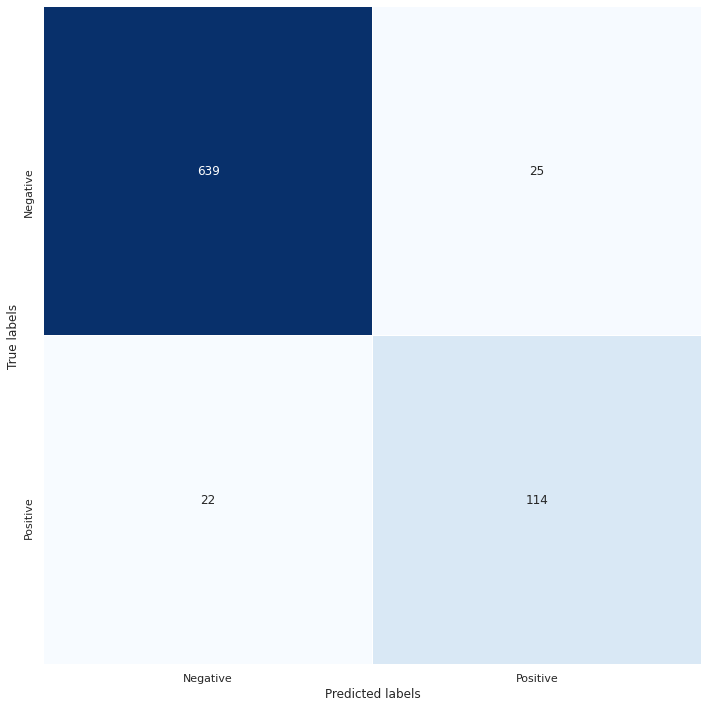

              precision    recall  f1-score   support

    Negative       0.97      0.96      0.96       664
    Positive       0.82      0.84      0.83       136

    accuracy                           0.94       800
   macro avg       0.89      0.90      0.90       800
weighted avg       0.94      0.94      0.94       800



In [6]:
predictions = np.array([1 if x >= 0.5 else 0 for x in seed_final_test])

cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Negative", "Positive"])

plt.figure(figsize=(10, 10))

sns.set(font_scale=1)

ax = sns.heatmap(cm_df, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.ylabel("True labels")
plt.xlabel("Predicted labels")
plt.tight_layout()

plt.show()

print(classification_report(y_test, predictions, target_names=["Negative", "Positive"]))

[0.         0.         0.         0.00150602 0.00150602 0.00301205
 0.00301205 0.0060241  0.0060241  0.00753012 0.00753012 0.00903614
 0.00903614 0.01054217 0.01054217 0.01656627 0.01656627 0.01957831
 0.01957831 0.02108434 0.02108434 0.02560241 0.02560241 0.02861446
 0.02861446 0.03012048 0.03012048 0.0376506  0.0376506  0.0436747
 0.0436747  0.04819277 0.04819277 0.05120482 0.05120482 0.06325301
 0.06325301 0.06927711 0.06927711 0.08584337 0.08584337 0.09186747
 0.09186747 0.09487952 0.09487952 0.09789157 0.09789157 0.13554217
 0.13554217 0.14006024 0.14006024 0.15210843 0.15210843 0.15361446
 0.15662651 0.16566265 0.16566265 0.16716867 0.17018072 0.17771084
 0.18072289 0.20180723 0.20180723 0.21084337 0.21385542 0.23795181
 0.23795181 0.24246988 0.24246988 0.2560241  0.2560241  0.27409639
 0.27710843 0.47590361 0.47590361 0.5813253  0.5813253  0.58885542
 0.59186747 0.75301205 0.75301205 0.82379518 0.82379518 0.84186747
 0.84487952 0.94427711 0.94728916 1.        ] [0.         0.007

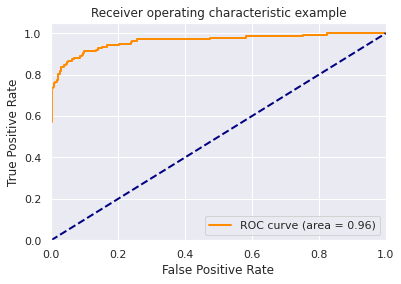

In [7]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

fpr, tpr, thresholds = roc_curve(y_test, seed_final_test, pos_label=1)
print(fpr, tpr, thresholds)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
         lw=lw, label="ROC curve (area = %0.2f)" % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()